# 2022-08-05 • Spiketrain correlations (of unconnected-but-detected)

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]


## Params

Based on Roxin; same as previous nb's.

In [6]:
d = 6
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1, 801],
);

## Run sim

In [7]:
s = cached(sim, [p.sim]);

Running simulation: 100%|███████████████████████████████| Time: 0:11:16mmmm
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\sim\ebefdc43edf54e31.jld2` … done (29.6 s)


In [8]:
s = augment_simdata(s, p);

## Bin spiketrains

In [17]:
function bin(events, binsize, duration)
    # `events` is a list of times, assumed sorted.
    # `duration` is of the events signal and determines the number of bins.
    num_bins = ceil(Int, duration / binsize)
    counts = fill(0, num_bins)
    i_event = 1
    bin_end = binsize
    for b in 1:num_bins
        while events[i_event] < bin_end
            counts[b] += 1
            i_event += 1
            if i_event > length(events)
                return counts
            end
        end
        bin_end += binsize
    end
end;

### Test

In [56]:
events = s.spike_times[1][1:10]
show(events)

[0.685, 1.9, 2.8, 6.86, 8.55, 8.65, 13.4, 15.3, 16.9, 17.1]

In [59]:
show(bin(events, 2, 20))

[2, 1, 0, 1, 2, 0, 1, 1, 2, 0]

Looks good

### Use

In [19]:
binned_spikes = [bin(s.spike_times[n], 100ms, 10minutes) for n in s.neuron_IDs];

## Correlation with recorded neuron

In [21]:
m = 1;  # analyzed neuron

In [25]:
cors = [cor(binned_spikes[m], binned_spikes[n]) for n in s.neuron_IDs];  # Pearson corr

## Split neurons by type

In [28]:
v = s.signals[m].v
ii = get_input_info(m, s, p);
ii.num_inputs

(exc = 26, inh = 10)

In [29]:
perf = evaluate_conntest_perf(v, ii.spiketrains, p);

Testing connections: 100%|██████████████████████████████| Time: 0:01:12


In [30]:
perf.detection_rates

(TPR_exc = 0.154, TPR_inh = 1, FPR = 0.15)

In [61]:
signif_unconn = ii.unconnected_neurons[findall(perf.p_values.unconn .< p.evaluation.α)];
tested_unconn = ii.unconnected_neurons[1:p.evaluation.N_tested_presyn]
insignif_unconn = [n for n in tested_unconn if n ∉ signif_unconn];

In [63]:
length(signif_unconn), length(insignif_unconn)

(6, 34)

## Plot

In [26]:
using PyPlot

In [27]:
using VoltoMapSim.Plot

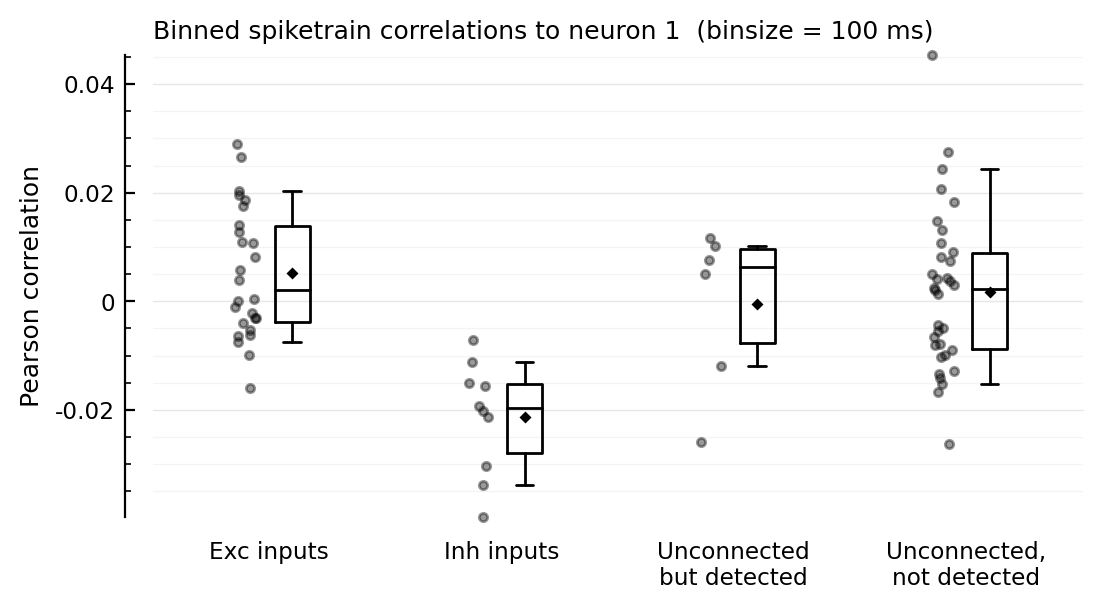

In [45]:
ydistplot(
    "Exc inputs" => cors[ii.exc_inputs],
    "Inh inputs" => cors[ii.inh_inputs],
    "Unconnected\nbut detected" => cors[signif_unconn],
    "Unconnected,\nnot detected" => cors[insignif_unconn],
    figsize = (6, 3),
    hylabel = "Binned spiketrain correlations to neuron $m  (binsize = 100 ms)",
    ylabel = "Pearson correlation",
    ylim = [-0.04, ]
);